# Models Comparison for TinyML

In [1]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)
tasks = ["2Labels", "3Labels", "4Labels", "5Labels"]
# Change this to change subtask
taskIndex = 3

In [3]:
with open('data/X.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y.pkl', 'rb') as f:
    y = pickle.load(f)

In [4]:
n_labels = 2 + taskIndex
samples = 30
X = X[:n_labels*samples]
y = y[:n_labels*samples]
labels = np.unique(y)

In [5]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [6]:
y = np.array([int(el) for el in y])
print(y)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print(X_test.shape)
print(y_test.shape)


(30, 42)
(30,)


In [8]:
y_test

array([3, 3, 2, 3, 1, 3, 0, 0, 4, 2, 4, 2, 1, 4, 1, 3, 2, 0, 1, 4, 0, 0,
       2, 3, 4, 2, 1, 0, 1, 4])

## Model Spotting

In [9]:
# Test options and evaluation metric
num_folds = 5
seed = 42
scoring = 'f1_macro'

In [11]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.99, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1)))
"""
if n_labels == 5:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=250, 
                                                           max_features=9, criterion='entropy', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))

else:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))
                                                          """


"\nif n_labels == 5:\n    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=250, \n                                                           max_features=9, criterion='entropy', max_depth=None,\n                                                           min_samples_split=4, min_samples_leaf=1\n                                                          )))\n\nelse:\n    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=100, \n                                                           max_features=5, criterion='gini', max_depth=None,\n                                                           min_samples_split=4, min_samples_leaf=1\n                                                          )))\n                                                          "

In [12]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,44 0,12
LR - 0,63 0,07
CART - 0,50 0,07
SVC - 0,70 0,06
RF - 0,78 0,06


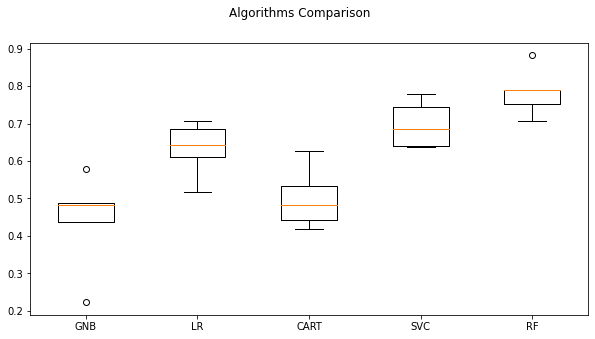

In [13]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [14]:
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2] if taskIndex > 1 else row[-3]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = labels[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[taskIndex] + "/classificationReports/" +'report' + model_name +  '.csv', index = False)
    
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    #classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.57      0.67      0.62         6
           2       0.00      0.00      0.00         6
           3       0.50      0.17      0.25         6
           4       0.24      0.67      0.35         6

    accuracy                           0.33        30
   macro avg       0.46      0.33      0.30        30
weighted avg       0.46      0.33      0.30        30

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.44      0.67      0.53         6
           2       0.57      0.67      0.62         6
           3       0.00      0.00      0.00         6
           4       1.00      0.67      0.80         6

    accuracy                           0.57        30
   macro avg       0.55      0.57      0.54   

# Neural Network

In [15]:
#Hyperparameters of NN
EPOCHS = 500 
BATCH_SIZE = 7
learn_rate = 0.001
nodes = 256
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.25))    
    model.add(layers.Dense(nodes, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [16]:
num_folds = 5

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 42)                1806      
_________________________________________________________________
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               11008     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
Total params: 14,099
Trainable params: 14,099
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
14/14 [==============================] - 0s 537us/step - loss: 1.6059 - accuracy: 0.2396
Epoch 2/500
14

14/14 [==============================] - 0s 600us/step - loss: 0.1216 - accuracy: 0.9583
Epoch 72/500
14/14 [==============================] - 0s 519us/step - loss: 0.0890 - accuracy: 0.9792
Epoch 73/500
14/14 [==============================] - 0s 586us/step - loss: 0.1281 - accuracy: 0.9792
Epoch 74/500
14/14 [==============================] - 0s 543us/step - loss: 0.0985 - accuracy: 0.9792
Epoch 75/500
14/14 [==============================] - 0s 584us/step - loss: 0.0789 - accuracy: 0.9896
Epoch 76/500
14/14 [==============================] - 0s 502us/step - loss: 0.1140 - accuracy: 1.0000
Epoch 77/500
14/14 [==============================] - 0s 540us/step - loss: 0.1035 - accuracy: 1.0000
Epoch 78/500
14/14 [==============================] - 0s 610us/step - loss: 0.1002 - accuracy: 0.9792
Epoch 79/500
14/14 [==============================] - 0s 496us/step - loss: 0.1195 - accuracy: 0.9792
Epoch 80/500
14/14 [==============================] - 0s 617us/step - loss: 0.1287 - accuracy: 

Epoch 151/500
14/14 [==============================] - 0s 541us/step - loss: 0.0264 - accuracy: 0.9896
Epoch 152/500
14/14 [==============================] - 0s 567us/step - loss: 0.0393 - accuracy: 1.0000
Epoch 153/500
14/14 [==============================] - 0s 504us/step - loss: 0.0410 - accuracy: 0.9792
Epoch 154/500
14/14 [==============================] - 0s 570us/step - loss: 0.0365 - accuracy: 0.9896
Epoch 155/500
14/14 [==============================] - 0s 545us/step - loss: 0.0575 - accuracy: 0.9896
Epoch 156/500
14/14 [==============================] - 0s 538us/step - loss: 0.0334 - accuracy: 0.9896
Epoch 157/500
14/14 [==============================] - 0s 525us/step - loss: 0.0435 - accuracy: 0.9688
Epoch 158/500
14/14 [==============================] - 0s 526us/step - loss: 0.0748 - accuracy: 0.9688
Epoch 159/500
14/14 [==============================] - 0s 544us/step - loss: 0.0189 - accuracy: 1.0000
Epoch 160/500
14/14 [==============================] - 0s 530us/step - lo

14/14 [==============================] - 0s 579us/step - loss: 0.0338 - accuracy: 0.9792
Epoch 231/500
14/14 [==============================] - 0s 569us/step - loss: 0.0106 - accuracy: 1.0000
Epoch 232/500
14/14 [==============================] - 0s 543us/step - loss: 0.0550 - accuracy: 0.9896
Epoch 233/500
14/14 [==============================] - 0s 593us/step - loss: 0.0209 - accuracy: 1.0000
Epoch 234/500
14/14 [==============================] - 0s 484us/step - loss: 0.0396 - accuracy: 0.9896
Epoch 235/500
14/14 [==============================] - 0s 563us/step - loss: 0.0305 - accuracy: 0.9896
Epoch 236/500
14/14 [==============================] - 0s 526us/step - loss: 0.0782 - accuracy: 0.9792
Epoch 237/500
14/14 [==============================] - 0s 565us/step - loss: 0.0434 - accuracy: 0.9792
Epoch 238/500
14/14 [==============================] - 0s 585us/step - loss: 0.0075 - accuracy: 1.0000
Epoch 239/500
14/14 [==============================] - 0s 540us/step - loss: 0.0198 - a

14/14 [==============================] - 0s 494us/step - loss: 0.0128 - accuracy: 1.0000
Epoch 310/500
14/14 [==============================] - 0s 623us/step - loss: 0.0157 - accuracy: 1.0000
Epoch 311/500
14/14 [==============================] - 0s 517us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 312/500
14/14 [==============================] - 0s 553us/step - loss: 0.0053 - accuracy: 1.0000
Epoch 313/500
14/14 [==============================] - 0s 582us/step - loss: 0.0196 - accuracy: 1.0000
Epoch 314/500
14/14 [==============================] - 0s 557us/step - loss: 0.0065 - accuracy: 1.0000
Epoch 315/500
14/14 [==============================] - 0s 554us/step - loss: 0.0180 - accuracy: 0.9896
Epoch 316/500
14/14 [==============================] - 0s 561us/step - loss: 0.0041 - accuracy: 1.0000
Epoch 317/500
14/14 [==============================] - 0s 568us/step - loss: 0.0058 - accuracy: 1.0000
Epoch 318/500
14/14 [==============================] - 0s 553us/step - loss: 0.0077 - a

14/14 [==============================] - 0s 596us/step - loss: 0.0143 - accuracy: 0.9896
Epoch 389/500
14/14 [==============================] - 0s 559us/step - loss: 0.0066 - accuracy: 1.0000
Epoch 390/500
14/14 [==============================] - 0s 552us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 391/500
14/14 [==============================] - 0s 495us/step - loss: 0.0255 - accuracy: 0.9896
Epoch 392/500
14/14 [==============================] - 0s 597us/step - loss: 0.0129 - accuracy: 1.0000
Epoch 393/500
14/14 [==============================] - 0s 603us/step - loss: 0.0081 - accuracy: 1.0000
Epoch 394/500
14/14 [==============================] - 0s 528us/step - loss: 0.0054 - accuracy: 1.0000
Epoch 395/500
14/14 [==============================] - 0s 583us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 396/500
14/14 [==============================] - 0s 528us/step - loss: 0.0085 - accuracy: 1.0000
Epoch 397/500
14/14 [==============================] - 0s 559us/step - loss: 0.0035 - a

14/14 [==============================] - 0s 517us/step - loss: 8.4249e-04 - accuracy: 1.0000
Epoch 468/500
14/14 [==============================] - 0s 590us/step - loss: 0.0103 - accuracy: 1.0000
Epoch 469/500
14/14 [==============================] - 0s 530us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 470/500
14/14 [==============================] - 0s 590us/step - loss: 0.0039 - accuracy: 1.0000
Epoch 471/500
14/14 [==============================] - 0s 560us/step - loss: 8.5845e-04 - accuracy: 1.0000
Epoch 472/500
14/14 [==============================] - 0s 577us/step - loss: 0.0045 - accuracy: 1.0000
Epoch 473/500
14/14 [==============================] - 0s 566us/step - loss: 0.0028 - accuracy: 1.0000
Epoch 474/500
14/14 [==============================] - 0s 549us/step - loss: 0.0020 - accuracy: 1.0000
Epoch 475/500
14/14 [==============================] - 0s 534us/step - loss: 0.0151 - accuracy: 0.9896
Epoch 476/500
14/14 [==============================] - 0s 497us/step - loss: 0.

14/14 [==============================] - 0s 536us/step - loss: 0.3850 - accuracy: 0.8646
Epoch 38/500
14/14 [==============================] - 0s 538us/step - loss: 0.3303 - accuracy: 0.9062
Epoch 39/500
14/14 [==============================] - 0s 578us/step - loss: 0.3051 - accuracy: 0.9167
Epoch 40/500
14/14 [==============================] - 0s 524us/step - loss: 0.2773 - accuracy: 0.9479
Epoch 41/500
14/14 [==============================] - 0s 540us/step - loss: 0.3084 - accuracy: 0.8854
Epoch 42/500
14/14 [==============================] - 0s 513us/step - loss: 0.2823 - accuracy: 0.9271
Epoch 43/500
14/14 [==============================] - 0s 616us/step - loss: 0.3465 - accuracy: 0.8854
Epoch 44/500
14/14 [==============================] - 0s 499us/step - loss: 0.2779 - accuracy: 0.9167
Epoch 45/500
14/14 [==============================] - 0s 592us/step - loss: 0.2710 - accuracy: 0.9271
Epoch 46/500
14/14 [==============================] - 0s 540us/step - loss: 0.2541 - accuracy: 

14/14 [==============================] - 0s 538us/step - loss: 0.0397 - accuracy: 0.9896
Epoch 118/500
14/14 [==============================] - 0s 510us/step - loss: 0.0416 - accuracy: 0.9896
Epoch 119/500
14/14 [==============================] - 0s 522us/step - loss: 0.0359 - accuracy: 1.0000
Epoch 120/500
14/14 [==============================] - 0s 584us/step - loss: 0.0400 - accuracy: 0.9896
Epoch 121/500
14/14 [==============================] - 0s 535us/step - loss: 0.0514 - accuracy: 0.9896
Epoch 122/500
14/14 [==============================] - 0s 524us/step - loss: 0.0516 - accuracy: 0.9896
Epoch 123/500
14/14 [==============================] - 0s 512us/step - loss: 0.0285 - accuracy: 1.0000
Epoch 124/500
14/14 [==============================] - 0s 530us/step - loss: 0.0417 - accuracy: 0.9896
Epoch 125/500
14/14 [==============================] - 0s 556us/step - loss: 0.0456 - accuracy: 1.0000
Epoch 126/500
14/14 [==============================] - 0s 583us/step - loss: 0.0661 - a

14/14 [==============================] - 0s 526us/step - loss: 0.0234 - accuracy: 1.0000
Epoch 197/500
14/14 [==============================] - 0s 570us/step - loss: 0.0473 - accuracy: 0.9792
Epoch 198/500
14/14 [==============================] - 0s 527us/step - loss: 0.0337 - accuracy: 0.9896
Epoch 199/500
14/14 [==============================] - 0s 529us/step - loss: 0.0083 - accuracy: 1.0000
Epoch 200/500
14/14 [==============================] - 0s 566us/step - loss: 0.0410 - accuracy: 0.9896
Epoch 201/500
14/14 [==============================] - 0s 576us/step - loss: 0.0071 - accuracy: 1.0000
Epoch 202/500
14/14 [==============================] - 0s 582us/step - loss: 0.0185 - accuracy: 0.9896
Epoch 203/500
14/14 [==============================] - 0s 486us/step - loss: 0.0090 - accuracy: 1.0000
Epoch 204/500
14/14 [==============================] - 0s 547us/step - loss: 0.0296 - accuracy: 0.9896
Epoch 205/500
14/14 [==============================] - 0s 619us/step - loss: 0.0085 - a

14/14 [==============================] - 0s 477us/step - loss: 0.0327 - accuracy: 0.9896
Epoch 276/500
14/14 [==============================] - 0s 516us/step - loss: 0.0236 - accuracy: 0.9896
Epoch 277/500
14/14 [==============================] - 0s 529us/step - loss: 0.0074 - accuracy: 1.0000
Epoch 278/500
14/14 [==============================] - 0s 547us/step - loss: 0.0173 - accuracy: 0.9896
Epoch 279/500
14/14 [==============================] - 0s 542us/step - loss: 0.0151 - accuracy: 1.0000
Epoch 280/500
14/14 [==============================] - 0s 670us/step - loss: 0.0133 - accuracy: 1.0000
Epoch 281/500
14/14 [==============================] - 0s 551us/step - loss: 0.0328 - accuracy: 0.9896
Epoch 282/500
14/14 [==============================] - 0s 531us/step - loss: 0.0072 - accuracy: 1.0000
Epoch 283/500
14/14 [==============================] - 0s 570us/step - loss: 0.0086 - accuracy: 1.0000
Epoch 284/500
14/14 [==============================] - 0s 543us/step - loss: 0.0118 - a

14/14 [==============================] - 0s 541us/step - loss: 0.0056 - accuracy: 1.0000
Epoch 355/500
14/14 [==============================] - 0s 508us/step - loss: 0.0039 - accuracy: 1.0000
Epoch 356/500
14/14 [==============================] - 0s 653us/step - loss: 0.0071 - accuracy: 1.0000
Epoch 357/500
14/14 [==============================] - 0s 525us/step - loss: 0.0205 - accuracy: 0.9896
Epoch 358/500
14/14 [==============================] - 0s 539us/step - loss: 0.0053 - accuracy: 1.0000
Epoch 359/500
14/14 [==============================] - 0s 554us/step - loss: 0.0070 - accuracy: 1.0000
Epoch 360/500
14/14 [==============================] - 0s 538us/step - loss: 0.0066 - accuracy: 1.0000
Epoch 361/500
14/14 [==============================] - 0s 545us/step - loss: 0.0107 - accuracy: 1.0000
Epoch 362/500
14/14 [==============================] - 0s 533us/step - loss: 0.0060 - accuracy: 1.0000
Epoch 363/500
14/14 [==============================] - 0s 611us/step - loss: 0.0020 - a

14/14 [==============================] - 0s 555us/step - loss: 0.0085 - accuracy: 1.0000
Epoch 434/500
14/14 [==============================] - 0s 583us/step - loss: 0.0014 - accuracy: 1.0000
Epoch 435/500
14/14 [==============================] - 0s 574us/step - loss: 0.0059 - accuracy: 1.0000
Epoch 436/500
14/14 [==============================] - 0s 604us/step - loss: 0.0082 - accuracy: 1.0000
Epoch 437/500
14/14 [==============================] - 0s 509us/step - loss: 0.0017 - accuracy: 1.0000
Epoch 438/500
14/14 [==============================] - 0s 579us/step - loss: 0.0039 - accuracy: 1.0000
Epoch 439/500
14/14 [==============================] - 0s 538us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 440/500
14/14 [==============================] - 0s 508us/step - loss: 0.0112 - accuracy: 0.9896
Epoch 441/500
14/14 [==============================] - 0s 589us/step - loss: 0.0090 - accuracy: 1.0000
Epoch 442/500
14/14 [==============================] - 0s 578us/step - loss: 0.0016 - a

14/14 [==============================] - 0s 575us/step - loss: 1.5603 - accuracy: 0.4583
Epoch 3/500
14/14 [==============================] - 0s 553us/step - loss: 1.4769 - accuracy: 0.6146
Epoch 4/500
14/14 [==============================] - 0s 623us/step - loss: 1.4080 - accuracy: 0.6250
Epoch 5/500
14/14 [==============================] - 0s 716us/step - loss: 1.3278 - accuracy: 0.6354
Epoch 6/500
14/14 [==============================] - 0s 645us/step - loss: 1.2639 - accuracy: 0.6354
Epoch 7/500
14/14 [==============================] - 0s 563us/step - loss: 1.1239 - accuracy: 0.7188
Epoch 8/500
14/14 [==============================] - 0s 620us/step - loss: 1.0368 - accuracy: 0.7083
Epoch 9/500
14/14 [==============================] - 0s 515us/step - loss: 0.9760 - accuracy: 0.7292
Epoch 10/500
14/14 [==============================] - 0s 515us/step - loss: 0.8828 - accuracy: 0.7500
Epoch 11/500
14/14 [==============================] - 0s 520us/step - loss: 0.8459 - accuracy: 0.7083


14/14 [==============================] - 0s 540us/step - loss: 0.0617 - accuracy: 1.0000
Epoch 83/500
14/14 [==============================] - 0s 540us/step - loss: 0.0610 - accuracy: 1.0000
Epoch 84/500
14/14 [==============================] - 0s 616us/step - loss: 0.0467 - accuracy: 1.0000
Epoch 85/500
14/14 [==============================] - 0s 582us/step - loss: 0.0441 - accuracy: 1.0000
Epoch 86/500
14/14 [==============================] - 0s 606us/step - loss: 0.0886 - accuracy: 0.9688
Epoch 87/500
14/14 [==============================] - 0s 568us/step - loss: 0.0491 - accuracy: 1.0000
Epoch 88/500
14/14 [==============================] - 0s 562us/step - loss: 0.0907 - accuracy: 0.9688
Epoch 89/500
14/14 [==============================] - 0s 553us/step - loss: 0.0998 - accuracy: 0.9792
Epoch 90/500
14/14 [==============================] - 0s 528us/step - loss: 0.0863 - accuracy: 0.9688
Epoch 91/500
14/14 [==============================] - 0s 557us/step - loss: 0.0649 - accuracy: 

14/14 [==============================] - 0s 565us/step - loss: 0.0203 - accuracy: 0.9896
Epoch 162/500
14/14 [==============================] - 0s 600us/step - loss: 0.0088 - accuracy: 1.0000
Epoch 163/500
14/14 [==============================] - 0s 544us/step - loss: 0.0308 - accuracy: 0.9896
Epoch 164/500
14/14 [==============================] - 0s 547us/step - loss: 0.0065 - accuracy: 1.0000
Epoch 165/500
14/14 [==============================] - 0s 525us/step - loss: 0.0065 - accuracy: 1.0000
Epoch 166/500
14/14 [==============================] - 0s 589us/step - loss: 0.0139 - accuracy: 1.0000
Epoch 167/500
14/14 [==============================] - 0s 574us/step - loss: 0.0456 - accuracy: 0.9896
Epoch 168/500
14/14 [==============================] - 0s 535us/step - loss: 0.0356 - accuracy: 0.9896
Epoch 169/500
14/14 [==============================] - 0s 605us/step - loss: 0.0134 - accuracy: 1.0000
Epoch 170/500
14/14 [==============================] - 0s 567us/step - loss: 0.0326 - a

14/14 [==============================] - 0s 601us/step - loss: 0.0180 - accuracy: 0.9896
Epoch 241/500
14/14 [==============================] - 0s 501us/step - loss: 0.0055 - accuracy: 1.0000
Epoch 242/500
14/14 [==============================] - 0s 598us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 243/500
14/14 [==============================] - 0s 564us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 244/500
14/14 [==============================] - 0s 606us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 245/500
14/14 [==============================] - 0s 577us/step - loss: 0.0240 - accuracy: 0.9896
Epoch 246/500
14/14 [==============================] - 0s 559us/step - loss: 0.0121 - accuracy: 1.0000
Epoch 247/500
14/14 [==============================] - 0s 726us/step - loss: 0.0113 - accuracy: 1.0000
Epoch 248/500
14/14 [==============================] - 0s 568us/step - loss: 0.0089 - accuracy: 1.0000
Epoch 249/500
14/14 [==============================] - 0s 566us/step - loss: 0.0064 - a

14/14 [==============================] - 0s 504us/step - loss: 0.0042 - accuracy: 1.0000
Epoch 320/500
14/14 [==============================] - 0s 534us/step - loss: 0.0083 - accuracy: 1.0000
Epoch 321/500
14/14 [==============================] - 0s 506us/step - loss: 0.0243 - accuracy: 0.9896
Epoch 322/500
14/14 [==============================] - 0s 504us/step - loss: 0.0090 - accuracy: 1.0000
Epoch 323/500
14/14 [==============================] - 0s 479us/step - loss: 0.0057 - accuracy: 1.0000
Epoch 324/500
14/14 [==============================] - 0s 498us/step - loss: 0.0164 - accuracy: 0.9896
Epoch 325/500
14/14 [==============================] - 0s 510us/step - loss: 0.0036 - accuracy: 1.0000
Epoch 326/500
14/14 [==============================] - 0s 483us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 327/500
14/14 [==============================] - 0s 488us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 328/500
14/14 [==============================] - 0s 543us/step - loss: 0.0041 - a

14/14 [==============================] - 0s 471us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 399/500
14/14 [==============================] - 0s 482us/step - loss: 0.0023 - accuracy: 1.0000
Epoch 400/500
14/14 [==============================] - 0s 482us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 401/500
14/14 [==============================] - 0s 493us/step - loss: 0.0074 - accuracy: 1.0000
Epoch 402/500
14/14 [==============================] - 0s 501us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 403/500
14/14 [==============================] - 0s 510us/step - loss: 0.0105 - accuracy: 1.0000
Epoch 404/500
14/14 [==============================] - 0s 474us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 405/500
14/14 [==============================] - 0s 486us/step - loss: 0.0099 - accuracy: 1.0000
Epoch 406/500
14/14 [==============================] - 0s 507us/step - loss: 0.0019 - accuracy: 1.0000
Epoch 407/500
14/14 [==============================] - 0s 487us/step - loss: 0.0030 - a

14/14 [==============================] - 0s 548us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 478/500
14/14 [==============================] - 0s 575us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 479/500
14/14 [==============================] - 0s 566us/step - loss: 0.0022 - accuracy: 1.0000
Epoch 480/500
14/14 [==============================] - 0s 541us/step - loss: 0.0085 - accuracy: 1.0000
Epoch 481/500
14/14 [==============================] - 0s 521us/step - loss: 0.0532 - accuracy: 0.9896
Epoch 482/500
14/14 [==============================] - 0s 573us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 483/500
14/14 [==============================] - 0s 538us/step - loss: 0.0035 - accuracy: 1.0000
Epoch 484/500
14/14 [==============================] - 0s 549us/step - loss: 0.0192 - accuracy: 0.9896
Epoch 485/500
14/14 [==============================] - 0s 616us/step - loss: 0.0155 - accuracy: 0.9896
Epoch 486/500
14/14 [==============================] - 0s 540us/step - loss: 0.0050 - a

14/14 [==============================] - 0s 548us/step - loss: 0.2264 - accuracy: 0.9375
Epoch 48/500
14/14 [==============================] - 0s 535us/step - loss: 0.2336 - accuracy: 0.9479
Epoch 49/500
14/14 [==============================] - 0s 586us/step - loss: 0.1904 - accuracy: 0.9375
Epoch 50/500
14/14 [==============================] - 0s 539us/step - loss: 0.1886 - accuracy: 0.9479
Epoch 51/500
14/14 [==============================] - 0s 585us/step - loss: 0.1852 - accuracy: 0.9479
Epoch 52/500
14/14 [==============================] - 0s 523us/step - loss: 0.1659 - accuracy: 0.9792
Epoch 53/500
14/14 [==============================] - 0s 547us/step - loss: 0.2065 - accuracy: 0.9167
Epoch 54/500
14/14 [==============================] - 0s 569us/step - loss: 0.1462 - accuracy: 0.9583
Epoch 55/500
14/14 [==============================] - 0s 520us/step - loss: 0.1988 - accuracy: 0.9375
Epoch 56/500
14/14 [==============================] - 0s 539us/step - loss: 0.1936 - accuracy: 

14/14 [==============================] - 0s 585us/step - loss: 0.0362 - accuracy: 1.0000
Epoch 128/500
14/14 [==============================] - 0s 523us/step - loss: 0.0452 - accuracy: 0.9896
Epoch 129/500
14/14 [==============================] - 0s 542us/step - loss: 0.0420 - accuracy: 0.9896
Epoch 130/500
14/14 [==============================] - 0s 541us/step - loss: 0.0516 - accuracy: 0.9688
Epoch 131/500
14/14 [==============================] - 0s 550us/step - loss: 0.0174 - accuracy: 1.0000
Epoch 132/500
14/14 [==============================] - 0s 559us/step - loss: 0.0182 - accuracy: 1.0000
Epoch 133/500
14/14 [==============================] - 0s 503us/step - loss: 0.0316 - accuracy: 0.9896
Epoch 134/500
14/14 [==============================] - 0s 480us/step - loss: 0.0333 - accuracy: 0.9896
Epoch 135/500
14/14 [==============================] - 0s 480us/step - loss: 0.1004 - accuracy: 0.9896
Epoch 136/500
14/14 [==============================] - 0s 483us/step - loss: 0.0266 - a

14/14 [==============================] - 0s 498us/step - loss: 0.0113 - accuracy: 1.0000
Epoch 207/500
14/14 [==============================] - 0s 516us/step - loss: 0.0108 - accuracy: 1.0000
Epoch 208/500
14/14 [==============================] - 0s 484us/step - loss: 0.0185 - accuracy: 1.0000
Epoch 209/500
14/14 [==============================] - 0s 517us/step - loss: 0.0096 - accuracy: 1.0000
Epoch 210/500
14/14 [==============================] - 0s 485us/step - loss: 0.0519 - accuracy: 0.9792
Epoch 211/500
14/14 [==============================] - 0s 489us/step - loss: 0.0302 - accuracy: 0.9896
Epoch 212/500
14/14 [==============================] - 0s 462us/step - loss: 0.0198 - accuracy: 1.0000
Epoch 213/500
14/14 [==============================] - 0s 500us/step - loss: 0.0249 - accuracy: 0.9896
Epoch 214/500
14/14 [==============================] - 0s 491us/step - loss: 0.0270 - accuracy: 0.9896
Epoch 215/500
14/14 [==============================] - 0s 489us/step - loss: 0.0122 - a

14/14 [==============================] - 0s 497us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 286/500
14/14 [==============================] - 0s 468us/step - loss: 0.0300 - accuracy: 0.9896
Epoch 287/500
14/14 [==============================] - 0s 510us/step - loss: 0.0205 - accuracy: 1.0000
Epoch 288/500
14/14 [==============================] - 0s 477us/step - loss: 0.0058 - accuracy: 1.0000
Epoch 289/500
14/14 [==============================] - 0s 481us/step - loss: 0.0024 - accuracy: 1.0000
Epoch 290/500
14/14 [==============================] - 0s 506us/step - loss: 0.0070 - accuracy: 1.0000
Epoch 291/500
14/14 [==============================] - 0s 497us/step - loss: 0.0073 - accuracy: 1.0000
Epoch 292/500
14/14 [==============================] - 0s 474us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 293/500
14/14 [==============================] - 0s 477us/step - loss: 0.0038 - accuracy: 1.0000
Epoch 294/500
14/14 [==============================] - 0s 491us/step - loss: 0.0117 - a

14/14 [==============================] - 0s 571us/step - loss: 0.0257 - accuracy: 0.9896
Epoch 365/500
14/14 [==============================] - 0s 531us/step - loss: 0.0504 - accuracy: 0.9792
Epoch 366/500
14/14 [==============================] - 0s 571us/step - loss: 0.0046 - accuracy: 1.0000
Epoch 367/500
14/14 [==============================] - 0s 561us/step - loss: 0.0175 - accuracy: 0.9896
Epoch 368/500
14/14 [==============================] - 0s 518us/step - loss: 0.0059 - accuracy: 1.0000
Epoch 369/500
14/14 [==============================] - 0s 593us/step - loss: 0.0318 - accuracy: 0.9896
Epoch 370/500
14/14 [==============================] - 0s 533us/step - loss: 0.0335 - accuracy: 0.9792
Epoch 371/500
14/14 [==============================] - 0s 616us/step - loss: 0.0064 - accuracy: 1.0000
Epoch 372/500
14/14 [==============================] - 0s 534us/step - loss: 0.0401 - accuracy: 0.9896
Epoch 373/500
14/14 [==============================] - 0s 577us/step - loss: 0.0029 - a

14/14 [==============================] - 0s 507us/step - loss: 0.0067 - accuracy: 1.0000
Epoch 444/500
14/14 [==============================] - 0s 536us/step - loss: 0.0032 - accuracy: 1.0000
Epoch 445/500
14/14 [==============================] - 0s 524us/step - loss: 0.0058 - accuracy: 1.0000
Epoch 446/500
14/14 [==============================] - 0s 519us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 447/500
14/14 [==============================] - 0s 482us/step - loss: 0.0166 - accuracy: 0.9896
Epoch 448/500
14/14 [==============================] - 0s 483us/step - loss: 0.0141 - accuracy: 0.9896
Epoch 449/500
14/14 [==============================] - 0s 522us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 450/500
14/14 [==============================] - 0s 487us/step - loss: 0.0016 - accuracy: 1.0000
Epoch 451/500
14/14 [==============================] - 0s 486us/step - loss: 0.0174 - accuracy: 0.9896
Epoch 452/500
14/14 [==============================] - 0s 486us/step - loss: 0.0101 - a

14/14 [==============================] - 0s 626us/step - loss: 0.7857 - accuracy: 0.7396
Epoch 13/500
14/14 [==============================] - 0s 577us/step - loss: 0.8394 - accuracy: 0.6979
Epoch 14/500
14/14 [==============================] - 0s 596us/step - loss: 0.7457 - accuracy: 0.7500
Epoch 15/500
14/14 [==============================] - 0s 558us/step - loss: 0.7046 - accuracy: 0.7500
Epoch 16/500
14/14 [==============================] - 0s 548us/step - loss: 0.7193 - accuracy: 0.7396
Epoch 17/500
14/14 [==============================] - 0s 544us/step - loss: 0.6494 - accuracy: 0.7708
Epoch 18/500
14/14 [==============================] - 0s 532us/step - loss: 0.6412 - accuracy: 0.7917
Epoch 19/500
14/14 [==============================] - 0s 546us/step - loss: 0.6232 - accuracy: 0.7917
Epoch 20/500
14/14 [==============================] - 0s 571us/step - loss: 0.6263 - accuracy: 0.7604
Epoch 21/500
14/14 [==============================] - 0s 570us/step - loss: 0.5739 - accuracy: 

14/14 [==============================] - 0s 484us/step - loss: 0.0880 - accuracy: 0.9896
Epoch 93/500
14/14 [==============================] - 0s 525us/step - loss: 0.0689 - accuracy: 0.9896
Epoch 94/500
14/14 [==============================] - 0s 521us/step - loss: 0.0742 - accuracy: 0.9896
Epoch 95/500
14/14 [==============================] - 0s 489us/step - loss: 0.0755 - accuracy: 0.9896
Epoch 96/500
14/14 [==============================] - 0s 505us/step - loss: 0.0819 - accuracy: 0.9896
Epoch 97/500
14/14 [==============================] - 0s 501us/step - loss: 0.0620 - accuracy: 0.9896
Epoch 98/500
14/14 [==============================] - 0s 513us/step - loss: 0.0611 - accuracy: 0.9792
Epoch 99/500
14/14 [==============================] - 0s 517us/step - loss: 0.0606 - accuracy: 0.9896
Epoch 100/500
14/14 [==============================] - 0s 506us/step - loss: 0.0940 - accuracy: 0.9583
Epoch 101/500
14/14 [==============================] - 0s 517us/step - loss: 0.0546 - accuracy

14/14 [==============================] - 0s 573us/step - loss: 0.0500 - accuracy: 0.9896
Epoch 172/500
14/14 [==============================] - 0s 544us/step - loss: 0.0121 - accuracy: 1.0000
Epoch 173/500
14/14 [==============================] - 0s 605us/step - loss: 0.0430 - accuracy: 0.9896
Epoch 174/500
14/14 [==============================] - 0s 544us/step - loss: 0.0802 - accuracy: 0.9792
Epoch 175/500
14/14 [==============================] - 0s 566us/step - loss: 0.0232 - accuracy: 1.0000
Epoch 176/500
14/14 [==============================] - 0s 533us/step - loss: 0.0218 - accuracy: 1.0000
Epoch 177/500
14/14 [==============================] - 0s 508us/step - loss: 0.0360 - accuracy: 0.9896
Epoch 178/500
14/14 [==============================] - 0s 566us/step - loss: 0.0394 - accuracy: 0.9896
Epoch 179/500
14/14 [==============================] - 0s 503us/step - loss: 0.0386 - accuracy: 0.9896
Epoch 180/500
14/14 [==============================] - 0s 589us/step - loss: 0.0470 - a

14/14 [==============================] - 0s 497us/step - loss: 0.0177 - accuracy: 1.0000
Epoch 251/500
14/14 [==============================] - 0s 512us/step - loss: 0.0369 - accuracy: 0.9896
Epoch 252/500
14/14 [==============================] - 0s 466us/step - loss: 0.0281 - accuracy: 0.9896
Epoch 253/500
14/14 [==============================] - 0s 492us/step - loss: 0.0198 - accuracy: 0.9896
Epoch 254/500
14/14 [==============================] - 0s 492us/step - loss: 0.0186 - accuracy: 1.0000
Epoch 255/500
14/14 [==============================] - 0s 499us/step - loss: 0.0078 - accuracy: 1.0000
Epoch 256/500
14/14 [==============================] - 0s 566us/step - loss: 0.0138 - accuracy: 1.0000
Epoch 257/500
14/14 [==============================] - 0s 550us/step - loss: 0.0158 - accuracy: 1.0000
Epoch 258/500
14/14 [==============================] - 0s 534us/step - loss: 0.0200 - accuracy: 1.0000
Epoch 259/500
14/14 [==============================] - 0s 532us/step - loss: 0.0195 - a

14/14 [==============================] - 0s 589us/step - loss: 0.0121 - accuracy: 0.9896
Epoch 330/500
14/14 [==============================] - 0s 520us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 331/500
14/14 [==============================] - 0s 600us/step - loss: 0.0087 - accuracy: 1.0000
Epoch 332/500
14/14 [==============================] - 0s 546us/step - loss: 0.0149 - accuracy: 0.9896
Epoch 333/500
14/14 [==============================] - 0s 556us/step - loss: 0.0063 - accuracy: 1.0000
Epoch 334/500
14/14 [==============================] - 0s 504us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 335/500
14/14 [==============================] - 0s 539us/step - loss: 0.0031 - accuracy: 1.0000
Epoch 336/500
14/14 [==============================] - 0s 558us/step - loss: 0.0148 - accuracy: 0.9896
Epoch 337/500
14/14 [==============================] - 0s 574us/step - loss: 0.0058 - accuracy: 1.0000
Epoch 338/500
14/14 [==============================] - 0s 555us/step - loss: 0.0147 - a

14/14 [==============================] - 0s 494us/step - loss: 0.0033 - accuracy: 1.0000
Epoch 409/500
14/14 [==============================] - 0s 472us/step - loss: 0.0491 - accuracy: 0.9896
Epoch 410/500
14/14 [==============================] - 0s 509us/step - loss: 0.0671 - accuracy: 0.9896
Epoch 411/500
14/14 [==============================] - 0s 502us/step - loss: 0.0461 - accuracy: 0.9792
Epoch 412/500
14/14 [==============================] - 0s 495us/step - loss: 0.0720 - accuracy: 0.9896
Epoch 413/500
14/14 [==============================] - 0s 502us/step - loss: 0.0081 - accuracy: 1.0000
Epoch 414/500
14/14 [==============================] - 0s 478us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 415/500
14/14 [==============================] - 0s 500us/step - loss: 0.0163 - accuracy: 1.0000
Epoch 416/500
14/14 [==============================] - 0s 506us/step - loss: 0.0251 - accuracy: 0.9896
Epoch 417/500
14/14 [==============================] - 0s 496us/step - loss: 0.0103 - a

14/14 [==============================] - 0s 522us/step - loss: 0.0030 - accuracy: 1.0000
Epoch 488/500
14/14 [==============================] - 0s 504us/step - loss: 0.0025 - accuracy: 1.0000
Epoch 489/500
14/14 [==============================] - 0s 523us/step - loss: 0.0673 - accuracy: 0.9792
Epoch 490/500
14/14 [==============================] - 0s 510us/step - loss: 0.0040 - accuracy: 1.0000
Epoch 491/500
14/14 [==============================] - 0s 488us/step - loss: 0.0342 - accuracy: 0.9896
Epoch 492/500
14/14 [==============================] - 0s 558us/step - loss: 0.0244 - accuracy: 0.9896
Epoch 493/500
14/14 [==============================] - 0s 567us/step - loss: 0.0109 - accuracy: 0.9896
Epoch 494/500
14/14 [==============================] - 0s 521us/step - loss: 0.0079 - accuracy: 1.0000
Epoch 495/500
14/14 [==============================] - 0s 535us/step - loss: 0.0062 - accuracy: 1.0000
Epoch 496/500
14/14 [==============================] - 0s 514us/step - loss: 0.0048 - a

## Train and Test

In [17]:
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 42)                1806      
_________________________________________________________________
dropout_10 (Dropout)         (None, 42)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               11008     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 1285      
Total params: 14,099
Trainable params: 14,099
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
13/13 [==============================] - 0s 6ms/step - loss: 1.6044 - accuracy: 0.2444 - val_loss: 1.59

13/13 [==============================] - 0s 1ms/step - loss: 0.2008 - accuracy: 0.9444 - val_loss: 0.7510 - val_accuracy: 0.7000
Epoch 52/500
13/13 [==============================] - 0s 1ms/step - loss: 0.1793 - accuracy: 0.9667 - val_loss: 0.7367 - val_accuracy: 0.7000
Epoch 53/500
13/13 [==============================] - 0s 1ms/step - loss: 0.2078 - accuracy: 0.9556 - val_loss: 0.7384 - val_accuracy: 0.7333
Epoch 54/500
13/13 [==============================] - 0s 1ms/step - loss: 0.2016 - accuracy: 0.9333 - val_loss: 0.7322 - val_accuracy: 0.7333
Epoch 55/500
13/13 [==============================] - 0s 1ms/step - loss: 0.2039 - accuracy: 0.9222 - val_loss: 0.7696 - val_accuracy: 0.7000
Epoch 56/500
13/13 [==============================] - 0s 1ms/step - loss: 0.1518 - accuracy: 0.9667 - val_loss: 0.7875 - val_accuracy: 0.7000
Epoch 57/500
13/13 [==============================] - 0s 1ms/step - loss: 0.1529 - accuracy: 0.9667 - val_loss: 0.7952 - val_accuracy: 0.7000
Epoch 58/500
13/13 

Epoch 109/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0438 - accuracy: 1.0000 - val_loss: 0.9341 - val_accuracy: 0.7000
Epoch 110/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0543 - accuracy: 1.0000 - val_loss: 0.8911 - val_accuracy: 0.7333
Epoch 111/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0544 - accuracy: 0.9889 - val_loss: 0.8681 - val_accuracy: 0.7667
Epoch 112/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0717 - accuracy: 0.9889 - val_loss: 0.8917 - val_accuracy: 0.7000
Epoch 113/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0319 - accuracy: 1.0000 - val_loss: 0.8817 - val_accuracy: 0.7333
Epoch 114/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0309 - accuracy: 1.0000 - val_loss: 0.8669 - val_accuracy: 0.7667
Epoch 115/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0384 - accuracy: 1.0000 - val_loss: 0.8902 - val_accuracy: 0.7000

13/13 [==============================] - 0s 1ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 1.1072 - val_accuracy: 0.7333
Epoch 167/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 1.1364 - val_accuracy: 0.7333
Epoch 168/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0173 - accuracy: 1.0000 - val_loss: 1.1471 - val_accuracy: 0.7333
Epoch 169/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 1.1211 - val_accuracy: 0.7333
Epoch 170/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0518 - accuracy: 0.9778 - val_loss: 1.2238 - val_accuracy: 0.7000
Epoch 171/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0660 - accuracy: 0.9889 - val_loss: 1.2276 - val_accuracy: 0.7000
Epoch 172/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0267 - accuracy: 1.0000 - val_loss: 1.1226 - val_accuracy: 0.7333
Epoch 173/500

13/13 [==============================] - 0s 2ms/step - loss: 0.0210 - accuracy: 0.9889 - val_loss: 1.1673 - val_accuracy: 0.7333
Epoch 224/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 1.1630 - val_accuracy: 0.7333
Epoch 225/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.1561 - val_accuracy: 0.7333
Epoch 226/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 1.1442 - val_accuracy: 0.7333
Epoch 227/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0261 - accuracy: 1.0000 - val_loss: 1.1271 - val_accuracy: 0.7333
Epoch 228/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0279 - accuracy: 0.9889 - val_loss: 1.1498 - val_accuracy: 0.7333
Epoch 229/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0139 - accuracy: 1.0000 - val_loss: 1.1886 - val_accuracy: 0.7333
Epoch 230/500

13/13 [==============================] - 0s 2ms/step - loss: 0.1249 - accuracy: 0.9889 - val_loss: 1.3162 - val_accuracy: 0.7333
Epoch 281/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0163 - accuracy: 1.0000 - val_loss: 1.3582 - val_accuracy: 0.7333
Epoch 282/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0695 - accuracy: 0.9889 - val_loss: 1.6068 - val_accuracy: 0.7000
Epoch 283/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.7381 - val_accuracy: 0.7000
Epoch 284/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0209 - accuracy: 1.0000 - val_loss: 1.6334 - val_accuracy: 0.7000
Epoch 285/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0260 - accuracy: 0.9889 - val_loss: 1.3285 - val_accuracy: 0.7333
Epoch 286/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 1.2457 - val_accuracy: 0.7333
Epoch 287/500

13/13 [==============================] - 0s 2ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.3382 - val_accuracy: 0.7000
Epoch 338/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0247 - accuracy: 0.9889 - val_loss: 1.3793 - val_accuracy: 0.7333
Epoch 339/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 1.4213 - val_accuracy: 0.7333
Epoch 340/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.4536 - val_accuracy: 0.7667
Epoch 341/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.4611 - val_accuracy: 0.7667
Epoch 342/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 1.4378 - val_accuracy: 0.7667
Epoch 343/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.3825 - val_accuracy: 0.7667
Epoch 344/500

13/13 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.3486 - val_accuracy: 0.7333
Epoch 395/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.3260 - val_accuracy: 0.7333
Epoch 396/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.3106 - val_accuracy: 0.7333
Epoch 397/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.2970 - val_accuracy: 0.7333
Epoch 398/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 1.3201 - val_accuracy: 0.7333
Epoch 399/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 1.3012 - val_accuracy: 0.7333
Epoch 400/500
13/13 [==============================] - 0s 1ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 1.3186 - val_accuracy: 0.7333
Epoch 401/500

13/13 [==============================] - 0s 2ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 1.5889 - val_accuracy: 0.7333
Epoch 452/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0140 - accuracy: 0.9889 - val_loss: 1.5068 - val_accuracy: 0.7333
Epoch 453/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.4123 - val_accuracy: 0.7667
Epoch 454/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 1.3988 - val_accuracy: 0.7667
Epoch 455/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.4003 - val_accuracy: 0.7667
Epoch 456/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0582 - accuracy: 0.9889 - val_loss: 1.4565 - val_accuracy: 0.7667
Epoch 457/500
13/13 [==============================] - 0s 2ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 1.7726 - val_accuracy: 0.7000
Epoch 458/500

In [18]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
report = classification_report(y_test, predictions_categorical)
print(report)
#classification_report_csv(report, "NN")

              precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       0.60      0.50      0.55         6
           2       1.00      1.00      1.00         6
           3       0.75      0.50      0.60         6
           4       0.83      0.83      0.83         6

    accuracy                           0.73        30
   macro avg       0.75      0.73      0.73        30
weighted avg       0.75      0.73      0.73        30



# Export Models in C code

In [19]:
# Neural network with TinyMLGen
with open(tasks[taskIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[taskIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpmpz1dalz/assets
